# Basic Classifiers experiments

In this Notebook, different types of basic classifiers are tested: **LogisticRegression**, **SVM** and **CRF[to come]**.

In [1]:
import numpy as np
import pickle
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from datasets import Dataset
from typing import List

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from utils.utils import get_dataset_input, get_dataset_label, get_predictions_from_logits, radar_plot

## Inspect results

In [3]:
with open("data/labels.json", "r") as f:
    LABELS = json.load(f)
    
with open("results/basics.pkl", "rb") as f:
    results = pickle.load(f)

### Strategy : threshold = 0.5

In [4]:
df = pd.read_csv("results/basics-df.csv").rename(columns = {"Unnamed: 0": "model"})
df.sort_values(by = "weighted_avg", ascending = False)

,model,context-AIC,contribution-AIC,result,impact,directions,limitation,outline-AIC,nc,micro_avg,macro_avg,weighted_avg,samples_avg
1,lr+cv+prefix_text,0.687351,0.494382,0.637594,0.117647,0.486486,0.120482,0.721311,0.770312,0.665313,0.504446,0.654527,0.623854
7,svm+cv+prefix_text,0.645503,0.484848,0.625000,0.000000,0.369231,0.149254,0.458333,0.806502,0.673684,0.442334,0.649682,0.602650
10,svm+tf+prefix_text,0.623656,0.460481,0.638079,0.222222,0.343750,0.121212,0.641509,0.800312,0.671308,0.481403,0.648485,0.599281
11,svm+tf+prefix_SEP,0.632708,0.455172,0.633391,0.222222,0.343750,0.123077,0.629630,0.797814,0.669846,0.479720,0.646843,0.598383
4,lr+tf+prefix_text,0.677083,0.487952,0.625786,0.222222,0.393939,0.083333,0.654545,0.759785,0.656664,0.488081,0.640467,0.605009
5,lr+tf+prefix_SEP,0.670157,0.480000,0.630573,0.222222,0.343750,0.086957,0.655172,0.756061,0.655028,0.480612,0.636587,0.602875
8,svm+cv+prefix_SEP,0.670025,0.489796,0.543651,0.000000,0.369231,0.149254,0.458333,0.800541,0.670383,0.435104,0.633361,0.624326
2,lr+cv+prefix_SEP,0.621849,0.394919,0.582441,0.080000,0.214464,0.174129,0.313131,0.673507,0.463593,0.381805,0.564431,0.487360
9,svm+tf+text,0.482143,0.380623,0.606474,0.125000,0.290323,0.089552,0.592593,0.696664,0.586667,0.407921,0.563917,0.516959
6,svm+cv+text,0.461538,0.379661,0.590909,0.000000,0.237288,0.089552,0.448980,0.700935,0.578178,0.363608,0.552971,0.500786


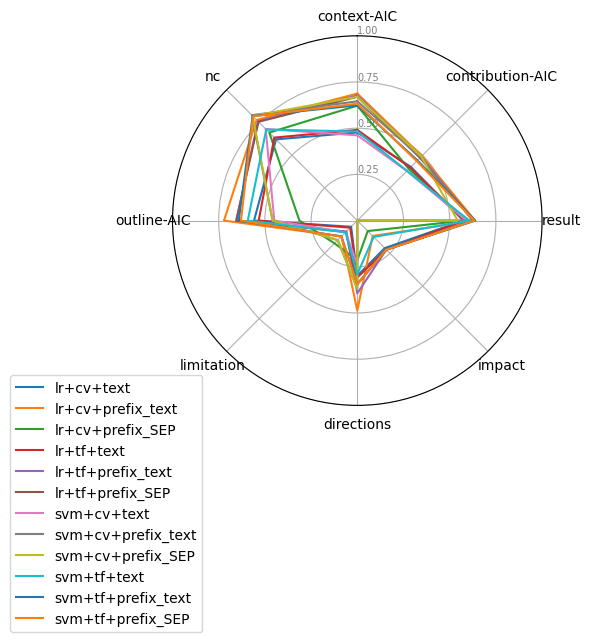

In [10]:
radar_plot(df[["model"] + LABELS])

### Strategy: constraints

In [41]:
# model2wf1 = {}
# for model_type in results.keys():
#     for tok_type in results[model_type].keys():
#         for input_type in results[model_type][tok_type].keys():
#             model_name = f"{model_type}+{tok_type}+{input_type}"
#             f1scores = {}
#             for i, l in enumerate(LABELS):
#                 f1scores[LABELS[i]] = results[model_type][tok_type][input_type]["classification_report_constraints"][str(i)]["f1-score"]

#             for score in results[model_type][tok_type][input_type]["classification_report_constraints"].keys():
#                 if "avg" in score:
#                     score_name = "_".join(score.split())   
#                     f1scores[score_name] = results[model_type][tok_type][input_type]["classification_report_constraints"][score]["f1-score"]
            
#             model2wf1[model_name] = f1scores

# df = pd.DataFrame(model2wf1).transpose()
# df.to_csv("results/basics-df-constraints.csv")
# df.sort_values(by = "weighted_avg", ascending = False)

In [7]:
df_c = pd.read_csv("results/basics-df-constraints.csv").rename(columns = {"Unnamed: 0": "model"})
df_c.sort_values(by = "weighted_avg", ascending = False)

,model,context-AIC,contribution-AIC,result,impact,directions,limitation,outline-AIC,nc,micro_avg,macro_avg,weighted_avg,samples_avg
7,svm+cv+prefix_text,0.704805,0.572254,0.642405,0.111111,0.471910,0.177215,0.666667,0.811470,0.700883,0.519730,0.684946,0.709007
11,svm+tf+prefix_SEP,0.665116,0.536443,0.669782,0.210526,0.465116,0.184211,0.646154,0.810382,0.696850,0.523466,0.681047,0.704852
10,svm+tf+prefix_text,0.662037,0.527536,0.670807,0.210526,0.470588,0.186667,0.615385,0.810108,0.695082,0.519207,0.679178,0.703055
1,lr+cv+prefix_text,0.689956,0.510309,0.637143,0.105263,0.452381,0.150538,0.716418,0.787972,0.670959,0.506248,0.663854,0.680121
8,svm+cv+prefix_SEP,0.694639,0.527950,0.581614,0.111111,0.476190,0.179487,0.620690,0.791639,0.681952,0.497915,0.655619,0.690701
4,lr+tf+prefix_text,0.677346,0.498599,0.640950,0.210526,0.390244,0.117647,0.677419,0.781135,0.668402,0.499233,0.655557,0.676774
5,lr+tf+prefix_SEP,0.671296,0.487252,0.637594,0.210526,0.457831,0.121951,0.666667,0.778426,0.667318,0.503943,0.653500,0.675651
6,svm+cv+text,0.536341,0.405970,0.635659,0.000000,0.395062,0.103896,0.539683,0.723730,0.613220,0.417543,0.593729,0.620732
9,svm+tf+text,0.523457,0.410714,0.625578,0.222222,0.395062,0.106667,0.606061,0.719718,0.610492,0.451185,0.592414,0.618374
0,lr+cv+text,0.497674,0.404938,0.565657,0.210526,0.258824,0.065217,0.536585,0.657915,0.547565,0.399667,0.541725,0.555031


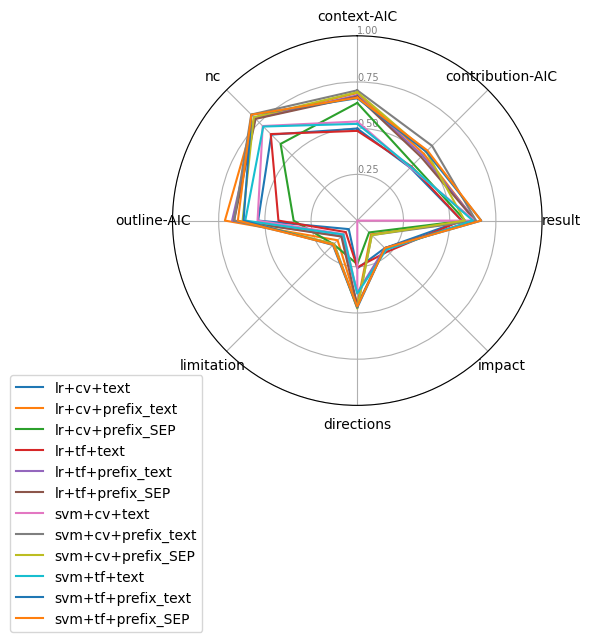

In [11]:
radar_plot(df_c[["model"] + LABELS])

## Data preparation

### Load train, eval and test splits

In [3]:
with open("data/train_final.pkl", "rb") as f:
    train_ds = pickle.load(f)

with open("data/eval_final.pkl", "rb") as f:
    eval_ds = pickle.load(f)

with open("data/test_final.pkl", "rb") as f:
    test_ds = pickle.load(f)

with open("data/labels.json", "r") as f:
    LABELS = json.load(f)

In [4]:
train_ds

Dataset({
    features: ['text', 'section', 'li', 'label', '-2', '-1', '+1'],
    num_rows: 11830
})

### Test different input / label formats 

In [6]:
input_data = {"text": {},
        "prefix_text": {},
        "prefix_SEP": {}}

for input_type in input_data.keys():
    for split, ds in zip(["train", "eval", "test"], [train_ds, eval_ds, test_ds]):
        input_data[input_type][split] = get_dataset_input(ds, path_to_data = "", type = input_type)

In [11]:
input_data["text"]["train"][0]

'We show that the transfer works better if the model is derived from the same task type.'

In [9]:
input_data["prefix_text"]["train"][0]

'section: Introduction, text: We show that the transfer works better if the model is derived from the same task type.'

In [10]:
input_data["prefix_SEP"]["train"][0]

'Introduction[SEC]We show that the transfer works better if the model is derived from the same task type.'

In [5]:
# we just use the default multi-label config (encoded as 1-hot vectors)
y_train = get_dataset_label(train_ds, path_to_data ="", LABELS = LABELS)
y_eval = get_dataset_label(eval_ds, path_to_data ="", LABELS = LABELS)
y_test = get_dataset_label(test_ds, path_to_data ="", LABELS = LABELS)

## Vectorization

### CountVectorizer

In [6]:
special_tokens = ["[SEC]", "[SEP]"]

for input_type in input_data.keys():
    print(input_type)
    ## FIT ON TRAIN
    X_train = input_data[input_type]["train"]
    
    # apply the vectorizer on train data
    count_vectorizer = CountVectorizer()
    X_train_cv = count_vectorizer.fit(X_train)

    # if needed, add special tokens to the dictionnary
    if "SEP" in input_type:
        vocab = count_vectorizer.vocabulary_
        for st in special_tokens:
            vocab[st] = len(vocab)
        count_vectorizer = CountVectorizer(vocabulary = vocab)

    X_train_cv = count_vectorizer.transform(X_train)

    # scale the data
    scaler = StandardScaler(with_mean = False)
    X_train_cv = scaler.fit_transform(X_train_cv)
    print("train with cv", X_train_cv.toarray().shape)

    # store the vectorized data
    input_data[input_type]["train_cv"] = X_train_cv

    ## APPLY ON EVAL AND TEST
    X_eval = input_data[input_type]["eval"]
    X_test = input_data[input_type]["test"]

    X_eval_cv = count_vectorizer.transform(X_eval)
    X_eval_cv = scaler.fit_transform(X_eval_cv)
    print("eval with cv", X_eval_cv.toarray().shape)
    input_data[input_type]["eval_cv"] = X_eval_cv

    X_test_cv = count_vectorizer.transform(X_test)
    X_test_cv = scaler.fit_transform(X_test_cv)
    print("test with cv", X_test_cv.toarray().shape)
    input_data[input_type]["test_cv"] = X_test_cv


text
train with cv (11830, 13307)
eval with cv (1478, 13307)
test with cv (1484, 13307)
prefix_text
train with cv (11830, 13342)
eval with cv (1478, 13342)
test with cv (1484, 13342)
prefix_SEP
train with cv (11830, 13344)
eval with cv (1478, 13344)
test with cv (1484, 13344)


### Tf-Idf Vectorizer

In [7]:
special_tokens = ["[SEC]", "[SEP]"]

for input_type in input_data.keys():
    print(input_type)
    ## FIT ON TRAIN
    X_train = input_data[input_type]["train"]
    
    # apply the vectorizer on train data
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tf = tfidf_vectorizer.fit(X_train)

    # if needed, add special tokens to the dictionnary
    if "SEP" in input_type:
        vocab = tfidf_vectorizer.vocabulary_
        for st in special_tokens:
            vocab[st] = len(vocab)
        tfidf_vectorizer = TfidfVectorizer(vocabulary = vocab)
        X_train_tf = tfidf_vectorizer.fit(X_train)
    
    X_train_tf = tfidf_vectorizer.transform(X_train)
    
    # scale the data
    scaler = StandardScaler(with_mean = False)
    X_train_tf = scaler.fit_transform(X_train_tf)
    print("train with tf", X_train_tf.toarray().shape)

    # store the vectorized data
    input_data[input_type]["train_tf"] = X_train_tf

    ## APPLY ON EVAL AND TEST
    X_eval = input_data[input_type]["eval"]
    X_test = input_data[input_type]["test"]

    X_eval_tf = tfidf_vectorizer.transform(X_eval)
    X_eval_tf = scaler.fit_transform(X_eval_tf)
    print("eval with tf", X_eval_tf.toarray().shape)
    input_data[input_type]["eval_tf"] = X_eval_tf

    X_test_tf = tfidf_vectorizer.transform(X_test)
    X_test_tf = scaler.fit_transform(X_test_tf)
    print("test with tf", X_test_tf.toarray().shape)
    input_data[input_type]["test_tf"] = X_test_tf


text
train with tf (11830, 13307)
eval with tf (1478, 13307)
test with tf (1484, 13307)
prefix_text
train with tf (11830, 13342)
eval with tf (1478, 13342)
test with tf (1484, 13342)
prefix_SEP


/home/clbleuze/myenv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1366: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


train with tf (11830, 13344)
eval with tf (1478, 13344)
test with tf (1484, 13344)


## Classification

In [8]:
results = {"lr": {"cv": {}, 
                 "tf": {}}}

### Logistic Regression

In [9]:
for input_type in input_data.keys():
    for vector_type in ["cv", "tf"]:
        X_train = input_data[input_type][f"train_{vector_type}"]

        # instantiate the classifier and apply it on the train data
        lr = OneVsRestClassifier(LogisticRegression(random_state = 42))
        lr.fit(X_train, y_train)

        # make predictions on the test set
        X_test = input_data[input_type][f"test_{vector_type}"]
        logits = lr.decision_function(X_test)

        preds = get_predictions_from_logits(logits, use_sigmoid = True)
        preds_constraints =  get_predictions_from_logits(logits, strategy = "constraints", use_sigmoid = True)

        # compute classification reports
        cr = classification_report(y_test, preds, zero_division = 0, output_dict = True)
        cr_constraints = classification_report(y_test, preds_constraints, zero_division = 0, output_dict = True)

        results["lr"][vector_type][input_type] = {
            "logits": logits,
            "preds": preds,
            "preds_constraints": preds_constraints,
            "classification_report": cr,
            "classification_report_constraints": cr_constraints,
            "model": lr,
        }

In [10]:
res = results["lr"]["tf"]["prefix_text"]
print(res["classification_report"]["weighted avg"]["f1-score"])
print(res["classification_report_constraints"]["weighted avg"]["f1-score"])

0.6404666296672259
0.6555568402380479


## SVM

In [11]:
results["svm"] = {"cv": {}, "tf": {}}

for input_type in input_data.keys():
    for vector_type in ["cv", "tf"]:
        X_train = input_data[input_type][f"train_{vector_type}"]

        # instantiate the classifier and apply it on the train data
        svm = OneVsRestClassifier(SVC(kernel = "sigmoid", C = 5, random_state = 42))
        svm.fit(X_train, y_train)

        # make predictions on the test set
        X_test = input_data[input_type][f"test_{vector_type}"]
        logits = svm.decision_function(X_test)

        preds = get_predictions_from_logits(logits, use_sigmoid = True)
        preds_constraints =  get_predictions_from_logits(logits, strategy = "constraints", use_sigmoid = True)

        # compute classification reports
        cr = classification_report(y_test, preds, zero_division = 0, output_dict = True)
        cr_constraints = classification_report(y_test, preds_constraints, zero_division = 0, output_dict = True)

        results["svm"][vector_type][input_type] = {
            "logits": logits,
            "preds": preds,
            "preds_constraints": preds_constraints,
            "classification_report": cr,
            "classification_report_constraints": cr_constraints,
            "model": svm,
        }

In [12]:
res = results["svm"]["tf"]["prefix_text"]
print(res["classification_report"]["weighted avg"]["f1-score"])
print(res["classification_report_constraints"]["weighted avg"]["f1-score"])

0.6484849609994903
0.6791783087604657


## CRF [to come]

In [13]:
# from sklearn_crfsuite import CRF

# results["crf"] = {"cv": {}, "tf": {}}

# for input_type in input_data.keys():
#     for vector_type in ["cv", "tf"]:
#         X_train = input_data[input_type][f"train_{vector_type}"]

#         # instantiate the classifier and apply it on the train data
#         crf = OneVsRestClassifier(CRF(
#             algorithm = "lbfgs",
#             c1 = 0.1,
#             c2 = 0.1,
#             max_iterations = 100,
#             all_possible_transitions = True,
#         ))
#         crf.fit(X_train, y_train)

#         # make predictions on the test set
#         X_test = input_data[input_type][f"test_{vector_type}"]
#         logits = crf.predict_marginals(X_test)

#         print(logits)
#         break
#     break
    
#         # preds = get_predictions_from_logits(logits, use_sigmoid = True)
#         # preds_constraints =  get_predictions_from_logits(logits, strategy = "constraints", use_sigmoid = True)

#         # # compute classification reports
#         # cr = classification_report(y_test, preds, zero_division = 0, output_dict = True)
#         # cr_constraints = classification_report(y_test, preds_constraints, zero_division = 0, output_dict = True)

#         # results["svm"][vector_type][input_type] = {
#         #     "logits": logits,
#         #     "preds": preds,
#         #     "preds_constraints": preds_constraints,
#         #     "classification_report": cr,
#         #     "classification_report_constraints": cr_constraints,
#         #     "model": crf,
#         # }

In [14]:
# X_train = input_data["text"]["train_cv"]
# X_test = input_data["text"]["test_cv"]

# X_train_dense = X_train.toarray()
# X_test_dense = X_test.toarray()

# def row_to_feature(row):
#     return {f'feature_{i}': value for i, value in enumerate(row)}

# X_train_features = [[row_to_feature(row) for row in tqdm(X_train_dense)]]
# X_test_features = [[row_to_feature(row) for row in tqdm(X_test_dense)]]

In [15]:
# y_train_str = [[str(elt) for elt in y_train]]
# y_train_str

In [16]:
# # instantiate the classifier and apply it on the train data
# from sklearn_crfsuite import CRF

# crf = OneVsRestClassifier(CRF(
#     algorithm = "lbfgs",
#     c1 = 0.1,
#     c2 = 0.1,
#     max_iterations = 100,
#     all_possible_transitions = True,
# ))

# crf.fit(X_train, y_train_str)

## Save results

In [17]:
with open("results/basics.pkl", "wb") as f:
    pickle.dump(results, f)